In [189]:
import numpy
import scipy, scipy.special, scipy.stats, scipy.optimize
from matplotlib import pyplot
import matplotlib.cm
%matplotlib nbagg

In [14]:
A = numpy.array(((1, 3, 5, 8), (2, -1, -2, 2), (-3, 4, 4, -1)))

In [15]:
b = numpy.array((2, 1, 6))

In [16]:
x = numpy.linalg.lstsq(A, b)[0]

In [19]:
x2 = numpy.linalg.lstsq(A.T @ A, A.T @ b)[0]

In [21]:
A @ x2

array([ 2.,  1.,  6.])

#### big splinge

##### potencial

In [58]:
data=numpy.fromfile("../data/inclination_database_iberia.dat", sep=" ")
t=data[0::4]; inc=data[2::4]; k=numpy.arange(t[0],t[-1],100); err=data[3::4]; terr=data[1::4]
terr[terr < 5] = 5

In [99]:
def time_v(t, t0, terr):
    return ((t0-terr < t) & (t < t0+terr))/(2*terr)

def value_v(v, v0, err):
    return scipy.stats.norm.pdf(v, v0, err)

def pot(t_grid, y_grid, t, y, terr, yerr):
    potential = numpy.zeros_like(t_grid)
    for ti, yi, terri, yerri in zip(t, y, terr, yerr):
        potential += -time_v(t_grid, ti, terri)*value_v(y_grid, yi, yerri)
    return potential

In [100]:
times = numpy.linspace(t[0], t[-1], 600)
vals = numpy.linspace(numpy.min(inc), numpy.max(inc), 600)

In [101]:
tt, yy = numpy.meshgrid(times, vals, indexing="ij")

In [102]:
zz = pot(tt, yy, t, inc, terr, err)

<IPython.core.display.Javascript object>


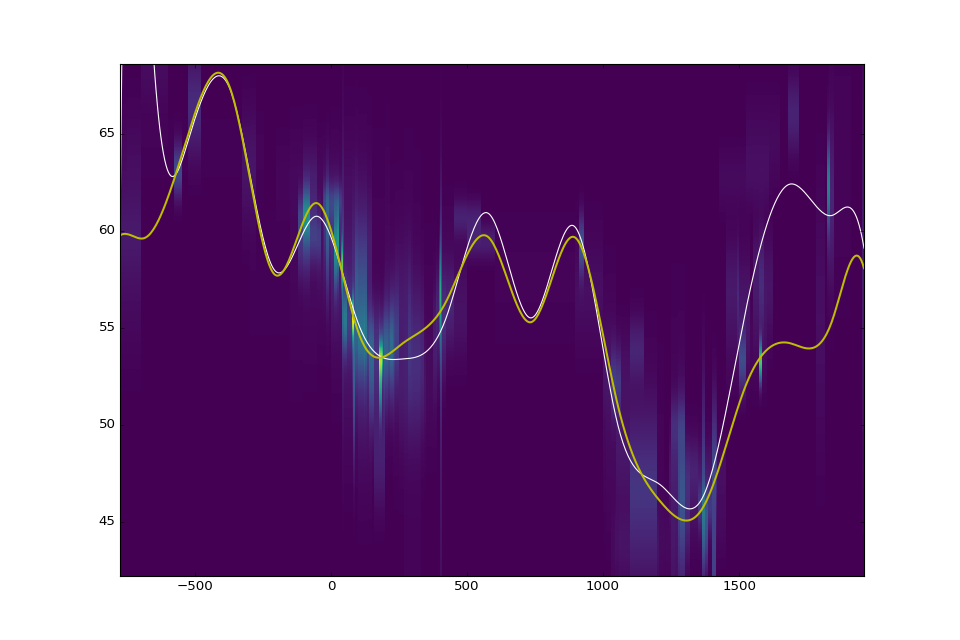

In [171]:
fig, ax = pyplot.subplots(figsize=(12, 8))

ax.pcolormesh(tt, yy, -zz, cmap="viridis")
ax.plot(times, bspline.condition_array(knots, times) @ initial_coefs, 'w')
ax.plot(times, bspline.condition_array(knots, times) @ final, 'y', linewidth=1.8)
ax.set_xbound(numpy.min(t), numpy.max(t))
ax.set_ybound(numpy.min(inc), numpy.max(inc))



##### splinge

In [71]:
import bspline

In [72]:
knots = numpy.linspace(-1000, 2000, 20)

<function bspline.condition_array>

AttributeError: module 'numpy' has no attribute 'eps'

In [141]:
times_eco = times[~numpy.isclose(sum([time_v(times, ti, terri) for ti, terri in zip(t, terr)]), 0)]

def residuals(spline_coefs, knots, times):
    yvals = bspline.condition_array(knots, times) @ spline_coefs
    return numpy.sum(pot(times, yvals, t, inc, terr, err))
    

In [175]:
def residuals_reg(spline_coefs, knots, times, reg_coef):
    yvals = bspline.condition_array(knots, times) @ spline_coefs
    norm = numpy.sum((numpy.diff(yvals, 2, axis=0)/(numpy.diff(times)**2)[:-1])**2)
    return numpy.sum(pot(times, yvals, t, inc, terr, err)) + norm*reg_coef

In [179]:
residuals_reg(initial_coefs, knots, times, 0.5)

-3.9669598150160139

In [180]:
initial_coefs = bspline.solve(t, inc, knots)

In [181]:
initial_coefs

array([-1824.8594954 ,   176.10704171,    56.56833421,    64.88497341,
          71.36358288,    53.06561016,    64.60160148,    53.0689665 ,
          53.46506644,    53.41907786,    65.39664896,    50.39455324,
          66.09464067,    46.6405182 ,    47.88098179,    43.23935538,
          57.05019577,    64.70765536,    58.53047851,    65.96701677])

In [146]:
#final_coefs=scipy.optimize.least_squares(residuals, initial_coefs, args=(knots, times))
final_coefs=scipy.optimize.minimize(residuals, initial_coefs, args=(knots, times_eco))

In [186]:
final_coefs=[scipy.optimize.minimize(residuals_reg, initial_coefs, args=(knots, times_eco, rc),
                                    options={"disp": True}).x for rc in numpy.logspace(-3, 10, 14)]

Optimization terminated successfully.
         Current function value: -4.240539
         Iterations: 155
         Function evaluations: 3476
         Gradient evaluations: 158
Optimization terminated successfully.
         Current function value: -4.240272
         Iterations: 159
         Function evaluations: 3542
         Gradient evaluations: 161
Optimization terminated successfully.
         Current function value: -4.237798
         Iterations: 150
         Function evaluations: 3366
         Gradient evaluations: 153
Optimization terminated successfully.
         Current function value: -4.301200
         Iterations: 193
         Function evaluations: 4510
         Gradient evaluations: 205
Optimization terminated successfully.
         Current function value: -4.216259
         Iterations: 196
         Function evaluations: 4708
         Gradient evaluations: 214
Optimization terminated successfully.
         Current function value: -4.095316
         Iterations: 236
         

<IPython.core.display.Javascript object>


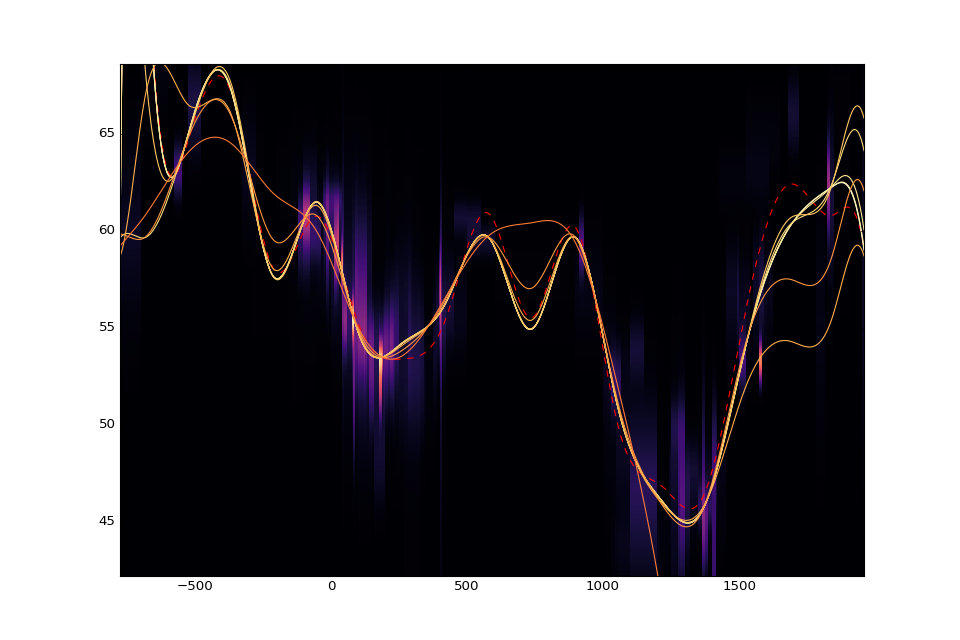

In [198]:
fig, ax = pyplot.subplots(figsize=(12, 8))

ax.pcolormesh(tt, yy, -zz, cmap="magma")
ax.plot(times, bspline.condition_array(knots, times) @ initial_coefs, 'r--')

colors = matplotlib.cm.YlOrRd(numpy.linspace(0, 1, len(final_coefs)))

for fc, lc in zip(final_coefs, colors):
    ax.plot(times, bspline.condition_array(knots, times) @ fc, color=lc, linewidth=1)
    
ax.set_xbound(numpy.min(t), numpy.max(t))
ax.set_ybound(numpy.min(inc), numpy.max(inc))



### big field test